In [ ]:
#Nota: May be used if you are behind a firewall and need to setup a proxy
import os
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"
import time
import numpy
start_time = time.perf_counter()
import pyFAI
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
print("Using pyFAI version", pyFAI.version)
import numpy as np
#initializes the visualization module to work with the jupyter notebook
%matplotlib inline
#Better user experience can be obtained with
# %matplotlib widget
from matplotlib.pyplot import subplots

In [ ]:
import fabio
from pyFAI.gui import jupyter
import matplotlib.pyplot as plt

# Load the image
img = fabio.open('5CNC0T_raw.tiff').data

# Set the minimum and maximum intensity values
vmin = 0  # minimum intensity value
vmax = 300  # maximum intensity value

# Display the image with specified intensity range
plt.imshow(img, vmin=vmin, vmax=vmax, cmap='viridis')
plt.title("Raw Image")
plt.colorbar()
plt.show()

In [ ]:
# Load the mask from an EDF file
#pygdatax_gui was used to draw the mask
mask_file = '5CNCmask.edf'
mask = fabio.open(mask_file).data

# Display the image with the mask applied
vmin = 0  # minimum intensity value
vmax = 300  # maximum intensity value
plt.imshow(np.ma.masked_array(img, mask),vmin=vmin, vmax=vmax, cmap='viridis')

plt.title("Raw Image with Mask")
plt.colorbar()
plt.show()

In [ ]:
import pyFAI, pyFAI.detectors
import numpy as np

# Use the specific detector class for PILATUS3 300
detector = pyFAI.detectors.Pilatus300k()
detector.mask = mask


# Method 2 to create mask. 
#mask = np.zeros(detector.shape, dtype=bool)
#mask = (img > 300) | (img <0.00010)


# Create an AzimuthalIntegrator with the detector
ai = AzimuthalIntegrator(detector=detector)
ai.wavelength = 1.542e-10  # 1.54 angstroms in meters
ai.setFit2D(1530.4453, 189.783, 368.952)

print(ai)


In [ ]:
# Integrate with units in inverse angstroms, applying the mask
res= ai.integrate1d_ng(img, 300, unit="q_A^-1", mask=mask)

# Display the integration result 
fig, ax = plt.subplots(figsize=(10, 5))
jupyter.plot1d(res, ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Integrated Data (log-log scale)")
ax.set_xlabel("q (1/Ang)")
ax.set_ylabel("Intensity")


In [ ]:
# Integrate with units in inverse angstroms and specified q limits, applying the mask
res= ai.integrate2d_ng(img, 300, unit="q_A^-1", mask=mask)

# Display the integration result 
fig, ax = plt.subplots(figsize=(10, 5))
jupyter.plot2d(res, ax=ax)


In [2]:
# List all .tiff files in the current directory
tiff_files = [f for f in os.listdir('.') if f.endswith('.tiff')]
print(tiff_files)

['5CNC0T_raw.tiff', '5CNC30T_raw.tiff']


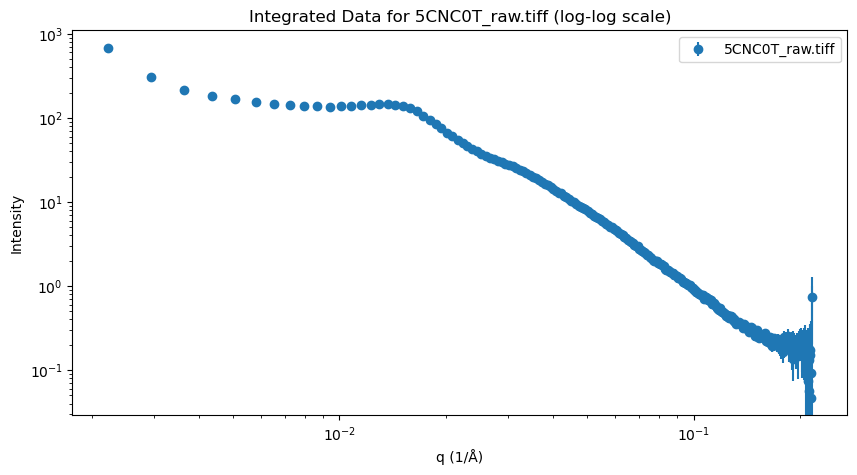

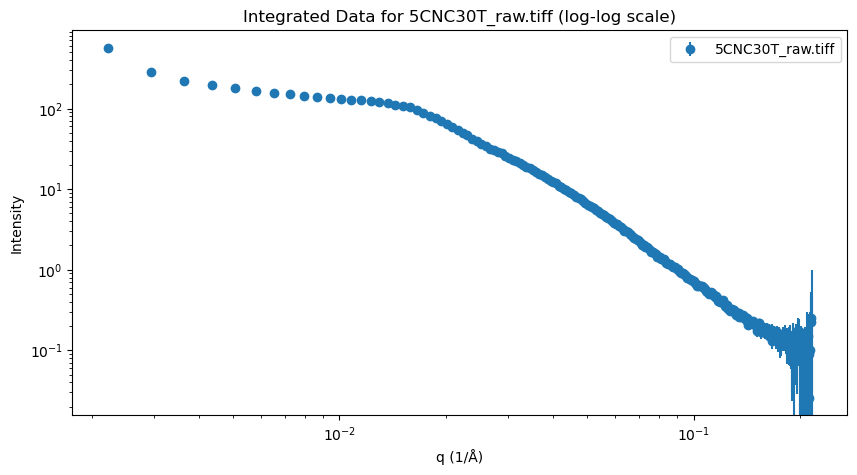

In [19]:
import os
import pyFAI
import fabio
import matplotlib.pyplot as plt
import pandas as pd

# Load the poni file. Assume all files uses the same poni settings
ai = pyFAI.load('cmalESAXS.poni')

# Load the mask. Asssume same mask for all
mask = fabio.open('5CNCmask.edf').data

# List all .tiff files in the current directory
tiff_files = [f for f in os.listdir('.') if f.endswith('.tiff')]

# Process each .tiff file
for tiff_file in tiff_files:
    # Load the image
    img = fabio.open(tiff_file).data
    
    # Perform the integration
    res = ai.integrate1d_ng(img, 300, unit="q_A^-1", mask=mask, method= 'bbox', error_model='poisson')
    

    # Save the result to a .dat file
    output_file = tiff_file.replace('.tiff', '.dat')
    with open(output_file, 'w') as f:
        f.write("# q (1/Å) Intensity dY\n")
        for q, intensity, dy in zip(res.radial, res.intensity, res.sigma):
            f.write(f"{q} {intensity} {dy}\n")
    
   # Display the integration result with error bars
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(res.radial, res.intensity, yerr=res.sigma, label=tiff_file, fmt='o')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f"Integrated Data for {tiff_file} (log-log scale)")
    ax.set_xlabel("q (1/Å)")
    ax.set_ylabel("Intensity")
    ax.legend()
    plt.show()